# tf-simple-metric-learningインストール
URL：https://github.com/daigo0927/tf-simple-metric-learning

In [ ]:
!pip install tf-simple-metric-learning

# インポート

In [2]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp

In [3]:
from tf_simple_metric_learning.layers import CircleLossCL

# MNISTデータロード

In [4]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [5]:
x_train = x_train.reshape((60000, 28, 28, 1))
x_test = x_test.reshape((10000, 28, 28, 1))
x_train = x_train / 255.0
x_test = x_test / 255.0

# モデル作成

In [6]:
NUM_CLASSES = 10
model_save_path = './mnist.hdf5'

In [7]:
# ベース構造作成
model_input = tf.keras.layers.Input((28, 28, 1))
embeds = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(model_input)
embeds = tf.keras.layers.MaxPooling2D((2, 2))(embeds)
embeds = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(embeds)
embeds = tf.keras.layers.MaxPooling2D((2, 2))(embeds)
embeds = tf.keras.layers.Conv2D(128, (3, 3), activation='relu')(embeds)
embeds = tf.keras.layers.Flatten()(embeds)
embeds = tf.keras.layers.Dense(1024)(embeds)

In [8]:
# メトリックレイヤー作成
metric_layer = CircleLossCL(num_classes=NUM_CLASSES, margin=0.25, scale=256)

In [9]:
labels = tf.keras.layers.Input([], dtype=tf.int32)
labels_onehot = tf.one_hot(labels, depth=NUM_CLASSES)

logits = metric_layer([embeds, labels_onehot])

In [10]:
model = tf.keras.Model(inputs=[model_input, labels], outputs=logits)

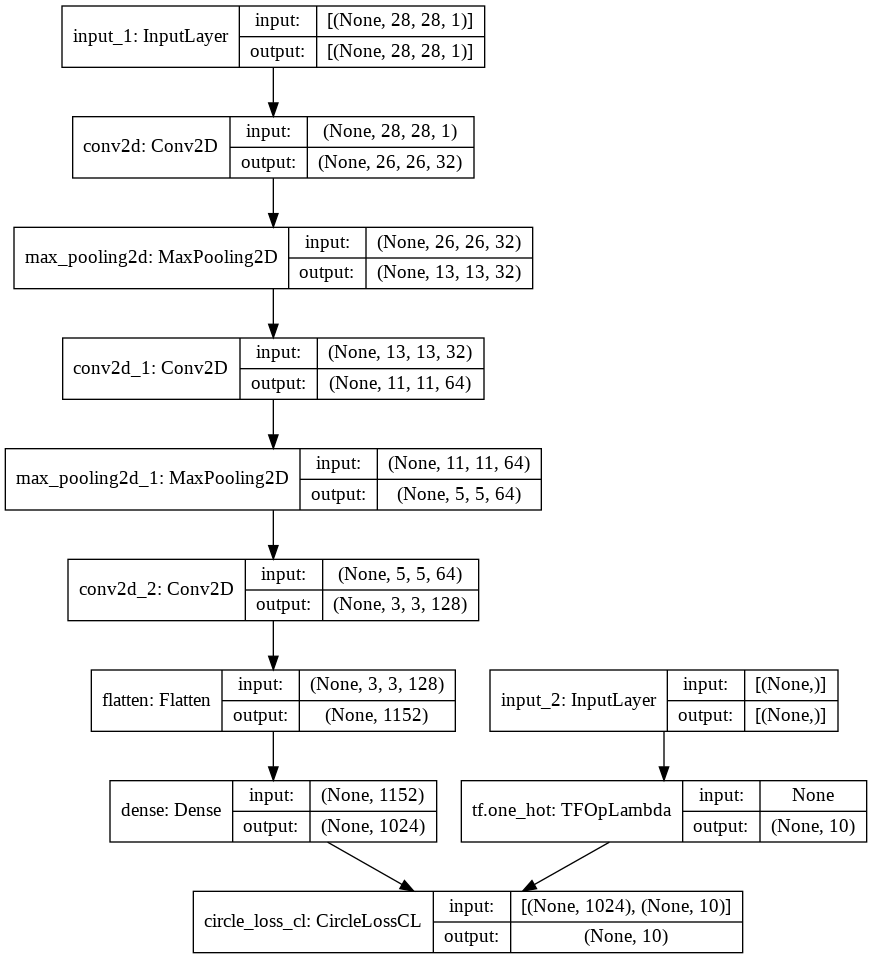

In [11]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [12]:
# モデルコンパイル
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=tf.keras.metrics.SparseCategoricalAccuracy()
)

# 学習

In [13]:
model.fit(
    [x_train, y_train], 
    y_train,
    epochs=100,
)

Epoch 1/100
1875/1875 [==============================] - 38s 3ms/step - loss: 18.4201 - sparse_categorical_accuracy: 0.7224
Epoch 2/100
1875/1875 [==============================] - 6s 3ms/step - loss: 3.4642 - sparse_categorical_accuracy: 0.9331
Epoch 3/100
1875/1875 [==============================] - 6s 3ms/step - loss: 2.3331 - sparse_categorical_accuracy: 0.9534
Epoch 4/100
1875/1875 [==============================] - 6s 3ms/step - loss: 1.7123 - sparse_categorical_accuracy: 0.9632
Epoch 5/100
1875/1875 [==============================] - 6s 3ms/step - loss: 1.3096 - sparse_categorical_accuracy: 0.9696
Epoch 6/100
1875/1875 [==============================] - 6s 3ms/step - loss: 1.0727 - sparse_categorical_accuracy: 0.9748
Epoch 7/100
1875/1875 [==============================] - 6s 3ms/step - loss: 0.8337 - sparse_categorical_accuracy: 0.9789
Epoch 8/100
1875/1875 [==============================] - 6s 3ms/step - loss: 0.7357 - sparse_categorical_accuracy: 0.9802
Epoch 9/100
1875/1875 

# 推論用モデル保存

In [14]:
# 推論用モデル取り出し
model = tf.keras.Model(inputs=model.input[0], outputs=model.layers[-3].output)

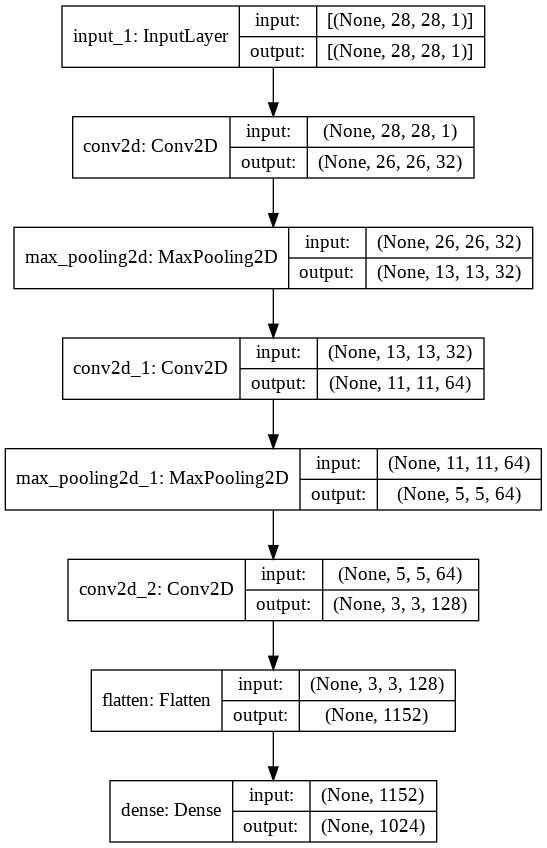

In [15]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [16]:
model.save(model_save_path)

# 推論テスト

In [17]:
# 保存したモデルのロード
load_model = tf.keras.models.load_model(model_save_path)

In [18]:
# 推論テスト
predict_result = load_model.predict(np.array([x_test[0]]))
print(np.squeeze(predict_result))

[201.44719   69.40858  -30.631294 ...  37.385574 -68.49626   76.53864 ]


# UMAP可視化

In [19]:
from tqdm import tqdm

predict_results = []
for x_test_data in tqdm(x_test):
    predict_result = load_model.predict(np.array([x_test_data]))
    predict_results.append(np.squeeze(predict_result))

100%|██████████| 10000/10000 [05:14<00:00, 31.75it/s]


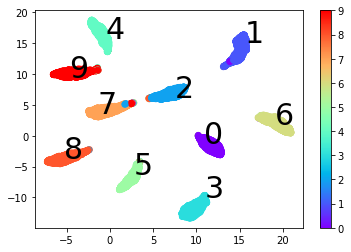

In [20]:
 from umap import UMAP
 import matplotlib.pyplot as plt

umap = UMAP(n_components=2)
umap.fit(predict_results)
embedding = umap.transform(predict_results)

plt.scatter(embedding[:, 0], embedding[:, 1], c=y_test, cmap='rainbow')
plt.colorbar()

for i in range(NUM_CLASSES):
    index = np.where(y_test==i)[0][0]
    plt.annotate(str(y_test[index]), (embedding[index, 0], embedding[index, 1]), size=30)

# コサイン類似度による距離比較

In [21]:
def cosine_similarity(x1, x2): 
    if x1.ndim == 1:
        x1 = x1[np.newaxis]
    if x2.ndim == 1:
        x2 = x2[np.newaxis]
    x1_norm = np.linalg.norm(x1, axis=1)
    x2_norm = np.linalg.norm(x2, axis=1)
    cosine_sim = np.dot(x1, x2.T)/(x1_norm*x2_norm+1e-10)
    return cosine_sim

In [22]:
result = load_model.predict(np.array([x_train[0]]))
print("正解値：" + str(y_train[0]))

正解値：5


In [23]:
similarity = cosine_similarity(np.array(result), np.array(predict_results))
similarity = np.squeeze(similarity)
most_similar_index = np.argmax(similarity)

print("コサイン類似度：" + str(similarity[most_similar_index]))
print("推測値：" + str(y_test[most_similar_index]))

コサイン類似度：0.98136777
推測値：5
